In [24]:
from oceanwave_forecast import data_manager
from oceanwave_forecast import data_pipeline
from oceanwave_forecast import config

from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.transformations.compose import ColumnEnsembleTransformer
from sklearn.preprocessing import StandardScaler

import os
import importlib
importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(config)


import hvplot.pandas  # registers the .hvplot accessor
import holoviews as hv
hv.extension('bokeh')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


2025-07-20 01:30:56.271 | INFO     | oceanwave_forecast.config:<module>:11 - PROJ_ROOT path is: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast


## DATA PROCESSING

In [11]:

# Define the paths to the three .txt files
folder1_txt = config.RAW_DATA_DIR / 'Standard meteorological data 2024' / '46088h2024.txt'
data_ocean = data_manager.extract_raw_data(folder1_txt)
data_ocean.head()

DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,
2024-01-01 00:00:00,90.0,2.3,3.5,99.00,99.0,99.00,999.0,1022.9,7.7,9.2,5.6,99.0,99.0
2024-01-01 00:10:00,103.0,2.4,3.2,0.15,99.0,4.45,999.0,1022.9,7.6,9.2,5.4,99.0,99.0
2024-01-01 00:20:00,95.0,2.1,3.1,99.00,99.0,99.00,999.0,1023.0,7.6,9.2,5.4,99.0,99.0
2024-01-01 00:30:00,95.0,1.7,2.2,99.00,99.0,99.00,999.0,1023.0,7.6,9.2,5.5,99.0,99.0
2024-01-01 00:40:00,98.0,1.4,2.2,0.16,99.0,4.67,999.0,1023.0,7.5,9.1,5.3,99.0,99.0


In [6]:
numerical_cols, categorical_cols = data_manager.DATAF_separate_columns(data_ocean)
disc_numerical_cols, conti_numerical_cols = data_manager.DATAF_separate_num_columns(data_ocean,numerical_cols, unique_threshold=20)


print("Number of Discrete Numerical Variables:", len(disc_numerical_cols))
print("Number of Continuous Numerical Variables:", len(conti_numerical_cols))
print("Number of Categorical Variables:", len(categorical_cols))
print(disc_numerical_cols)

Number of Discrete Numerical Variables: 2
Number of Continuous Numerical Variables: 11
Number of Categorical Variables: 0
['VIS', 'TIDE']


In [17]:


col_names = ['WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'DPD','MWD','PRES', 'ATMP', 'WTMP', 'DEWP']

# fixed 3‑month window
ts_start, ts_end = pd.to_datetime(config.START_DATE), pd.to_datetime(config.END_DATE)
data_ocean_hourly = data_ocean.resample('H').mean()

plots = []
for col_name in col_names:
    # slice the hourly data
    segment = data_ocean_hourly[col_name].loc[config.START_DATE:config.END_DATE]
    # backfill imputation
    imputed = segment.fillna(method='bfill')
    
    # 1) blue line of the imputed series
    main_curve = imputed.hvplot(
        kind='line',
        line_color='blue',
        marker='.',
        title=f"{col_name} (Jan–Mar 2024) with Imputation",
        ylabel=col_name,
        xlabel='Time',
        width=900,
        height=300,
        xlim=(ts_start, ts_end)
    )

    # 2) red scatter at imputed points
    imputed_pts = imputed[segment.isna()].hvplot(
        kind='scatter',
        color='red',
        marker='o',
        size=6,
        legend=False
    )

    # 3) overlay and collect
    plots.append(main_curve * imputed_pts)

# stack vertically
layout = hv.Layout(plots).cols(1)

# display
layout

C:\Users\akashv22\AppData\Local\Temp\ipykernel_13584\805551091.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean.resample('H').mean()
C:\Users\akashv22\AppData\Local\Temp\ipykernel_13584\805551091.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imputed = segment.fillna(method='bfill')


:Layout
   .Overlay.WDIR :Overlay
      .Curve.WDIR   :Curve   [datetime]   (WDIR)
      .Scatter.WDIR :Scatter   [datetime]   (WDIR)
   .Overlay.WSPD :Overlay
      .Curve.WSPD   :Curve   [datetime]   (WSPD)
      .Scatter.WSPD :Scatter   [datetime]   (WSPD)
   .Overlay.GST  :Overlay
      .Curve.GST   :Curve   [datetime]   (GST)
      .Scatter.GST :Scatter   [datetime]   (GST)
   .Overlay.WVHT :Overlay
      .Curve.WVHT   :Curve   [datetime]   (WVHT)
      .Scatter.WVHT :Scatter   [datetime]   (WVHT)
   .Overlay.APD  :Overlay
      .Curve.APD   :Curve   [datetime]   (APD)
      .Scatter.APD :Scatter   [datetime]   (APD)
   .Overlay.DPD  :Overlay
      .Curve.DPD   :Curve   [datetime]   (DPD)
      .Scatter.DPD :Scatter   [datetime]   (DPD)
   .Overlay.MWD  :Overlay
      .Curve.MWD   :Curve   [datetime]   (MWD)
      .Scatter.MWD :Scatter   [datetime]   (MWD)
   .Overlay.PRES :Overlay
      .Curve.PRES   :Curve   [datetime]   (PRES)
      .Scatter.PRES :Scatter   [datetime]   (PRES)
   .Overlay.ATMP :Overlay
      .Curve.ATMP   :Curve   [datetime]   (ATMP)
      .Scatter.ATMP :Scatter   [datetime]   (ATMP)
   .Overlay.WTMP :Overlay
      .Curve.WTMP   :Curve   [datetime]   (WTMP)
      .Scatter.WTMP :Scatter   [datetime]   (WTMP)
   .Overlay.DEWP :Overlay
      .Curve.DEWP   :Curve   [datetime]   (DEWP)
      .Scatter.DEWP :Scatter   [datetime]   (DEWP)

Processed ocean data undergoes the following steps:

1. A mapping for missing values is defined. Specific values for various columns (e.g., 99.0 for certain wind and temperature fields) are converted to NaN.
2. Unnecessary columns (namely 'TIDE', 'VIS', and 'DPD') are removed.
3. A transformer (MissingValueMarker) applies the missing value mapping, and a degree-to-cyclic transformer converts the 'WDIR' and 'MWD' features to their sine and cosine components.
4. Finally, the dataset is resampled to hourly intervals using the mean values.

This workflow ensures that the data is cleansed, transformed, and aggregated for further analysis.

In [14]:
processed_data = data_pipeline.preprocess_ocean_data(data_ocean)
processed_data.info()
processed_data = processed_data.loc[config.START_DATE:config.END_DATE]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   WSPD      8776 non-null   float64
 1   GST       8776 non-null   float64
 2   WVHT      8773 non-null   float64
 3   APD       8773 non-null   float64
 4   PRES      8776 non-null   float64
 5   ATMP      8776 non-null   float64
 6   WTMP      8776 non-null   float64
 7   DEWP      8776 non-null   float64
 8   WDIR_sin  8772 non-null   float64
 9   WDIR_cos  8772 non-null   float64
 10  MWD_sin   5425 non-null   float64
 11  MWD_cos   5425 non-null   float64
dtypes: float64(12)
memory usage: 892.1 KB


D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


## MODEL BASED IMPUTATION
Processed using a model-based imputation strategy for the angular features, where the ARIMA forecaster is leveraged. In this step:

• The ARIMA model is automatically tuned (searching over appropriate p and q ranges) to capture the underlying behavior of the time series, including trends, seasonality, and cyclical patterns.

• The goal is to impute missing values in the special columns (here, the sine and cosine transformed wind direction components) with forecasts that reflect the inherent dynamics of the data, leading to reasonable, pattern-consistent estimates.

• Meanwhile, simpler imputation (forward-fill) is applied to other variables, ensuring a robust and context-aware filling approach in the overall preprocessing pipeline.

In [15]:
special_cols = ['MWD_sin', 'MWD_cos']
other_cols = [col for col in processed_data.columns if col not in special_cols]


auto_arima = AutoARIMA(
    # let it search p=1..5, q=0..5, d determined by unit‐root tests
    start_p=1, max_p=3,
    start_q=0, max_q=3,
    d=None,
    # no periodic seasonality for angle components
    seasonal=False,
    stepwise=True,
    information_criterion="aic",
    suppress_warnings=True,
    n_jobs=-1,
)

imputer_pipe = ColumnEnsembleTransformer(
    transformers=[
        # ARIMA imputer only on the special columns
        ("arima_imp", Imputer(method="forecaster", forecaster=auto_arima), special_cols),
        # ffill imputer on all the *other* columns
        ("ffill_imp", Imputer(method="ffill"),other_cols),
    ],
    remainder="passthrough",  # or "drop" if you don't want any extra cols
)


processed_data_imputed = imputer_pipe.fit_transform(processed_data)


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [ ]:
# Comparing the original and imputed data
col_names = list(processed_data_imputed.columns)

missing_map = {
    # wind & gust & dominant-period wave:  99 → NaN
    'WSPD': 99.0,
    'GST':  99.0,
    'DPD':  99.0,
    'WVHT': 99.0,
    'APD': 99.0,

    # pressure: 9999 → NaN
    'PRES': 9999.0,

    # air, water & dew temps: 999 → NaN
    'ATMP': 999.0,
    'WTMP': 999.0,
    'DEWP': 999.0,
}
# instantiate and transform
mv_marker = data_pipeline.MissingValueMarker(missing_map)
deg2rad = data_pipeline.DegreeToCyclic(columns=['WDIR', 'MWD'])

data_ocean_hourly = mv_marker.transform(data_ocean_hourly)
data_ocean_hourly = deg2rad.transform(data_ocean_hourly)



plots = []
for col_name in col_names:
    # Original data
    segment = data_ocean_hourly[col_name].loc[config.START_DATE:config.END_DATE]
    # processed data
    imputed = processed_data_imputed[col_name].loc[config.START_DATE:config.END_DATE]
    
    main_curve = imputed.hvplot(
        kind='line',
        line_color='blue',
        marker='.',
        title=f"{col_name} (Jan–Mar 2024) with Imputation",
        ylabel=col_name,
        xlabel='Time',
        width=900,
        height=300,
        xlim=(ts_start, ts_end)
    )

    # 2) red scatter at imputed points
    imputed_pts = imputed[segment.isna()].hvplot(
        kind='scatter',
        color='red',
        marker='o',
        size=6,
        legend=False
    )

    # 3) overlay and collect
    plots.append(main_curve * imputed_pts)

# stack vertically
layout = hv.Layout(plots).cols(1)

# display
layout

:Layout
   .Overlay.MWD_sin  :Overlay
      .Curve.MWD_sin   :Curve   [datetime]   (MWD_sin)
      .Scatter.MWD_sin :Scatter   [datetime]   (MWD_sin)
   .Overlay.MWD_cos  :Overlay
      .Curve.MWD_cos   :Curve   [datetime]   (MWD_cos)
      .Scatter.MWD_cos :Scatter   [datetime]   (MWD_cos)
   .Overlay.WSPD     :Overlay
      .Curve.WSPD   :Curve   [datetime]   (WSPD)
      .Scatter.WSPD :Scatter   [datetime]   (WSPD)
   .Overlay.GST      :Overlay
      .Curve.GST   :Curve   [datetime]   (GST)
      .Scatter.GST :Scatter   [datetime]   (GST)
   .Overlay.WVHT     :Overlay
      .Curve.WVHT   :Curve   [datetime]   (WVHT)
      .Scatter.WVHT :Scatter   [datetime]   (WVHT)
   .Overlay.APD      :Overlay
      .Curve.APD   :Curve   [datetime]   (APD)
      .Scatter.APD :Scatter   [datetime]   (APD)
   .Overlay.PRES     :Overlay
      .Curve.PRES   :Curve   [datetime]   (PRES)
      .Scatter.PRES :Scatter   [datetime]   (PRES)
   .Overlay.ATMP     :Overlay
      .Curve.ATMP   :Curve   [datetime]   (ATMP)
      .Scatter.ATMP :Scatter   [datetime]   (ATMP)
   .Overlay.WTMP     :Overlay
      .Curve.WTMP   :Curve   [datetime]   (WTMP)
      .Scatter.WTMP :Scatter   [datetime]   (WTMP)
   .Overlay.DEWP     :Overlay
      .Curve.DEWP   :Curve   [datetime]   (DEWP)
      .Scatter.DEWP :Scatter   [datetime]   (DEWP)
   .Overlay.WDIR_sin :Overlay
      .Curve.WDIR_sin   :Curve   [datetime]   (WDIR_sin)
      .Scatter.WDIR_sin :Scatter   [datetime]   (WDIR_sin)
   .Overlay.WDIR_cos :Overlay
      .Curve.WDIR_cos   :Curve   [datetime]   (WDIR_cos)
      .Scatter.WDIR_cos :Scatter   [datetime]   (WDIR_cos)

# ANALYSING TARGET VARIABLES


=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -6.5026
Results: {'pvalue': 1.1519263826740688e-08, 'stationary': True, 'test_statistic': -6.502593796149434, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 37 49 61]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 4.4170259923875986e-11


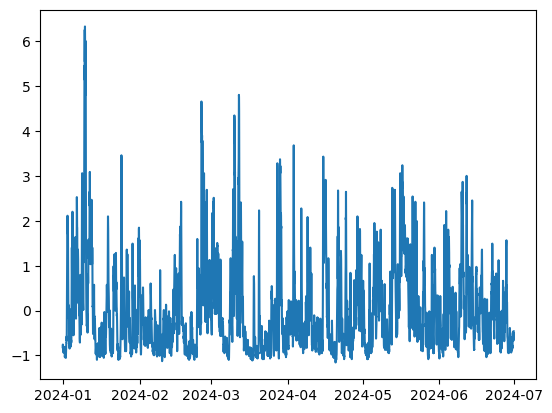


=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -5.9373
Results: {'pvalue': 2.3050856439624958e-07, 'stationary': True, 'test_statistic': -5.937268408888629, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 36 50]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 1.2501721968082412e-06


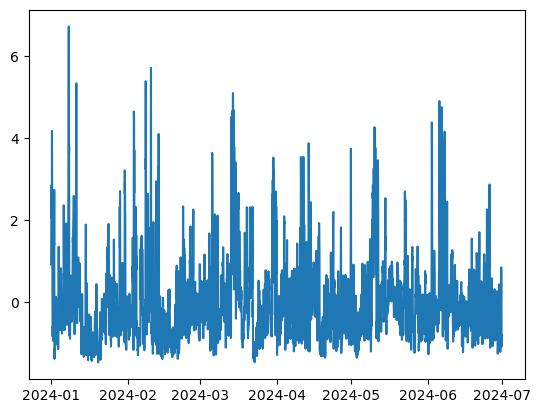

In [25]:



for col in config.TARGETS:

    col_series = processed_data_imputed[col]
    pipe = TransformerPipeline(
            steps = [
                # ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))),
                # ("deseasonalizer", Deseasonalizer(sp=24)),
                # ("deseasonalizer2", Deseasonalizer(sp=24*2)),
                ('scale', TabularToSeriesAdaptor(StandardScaler()))
            ]
        )

    col_transf = pipe.fit_transform(col_series)

    data_manager.test_stationarity(col_transf, plot = False)
    mann_kendall_res = data_manager.check_trend(col_transf, confidence=0.05)
    print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} ")

    seasonality_res = data_manager.check_seasonality(col_transf, max_lag=24*3, confidence=0.05)
    print(f"Seasonality identified for: {seasonality_res.seasonal_periods}")

    hetero_res = data_manager.check_heteroscedastisticity(col_transf, confidence=0.05)
    print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

    plt.plot(col_transf)
    plt.show()



# ANALYSIS OF EXOG VARIABLES

MWD_sin

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -5.8568
Results: {'pvalue': 3.484868260136387e-07, 'stationary': True, 'test_statistic': -5.856792117605843, 'used_lag': 24}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[49]
Seasonality identified for: 49
White Test for Heteroscedasticity: True with a p-value of 1.3550740655184857e-106


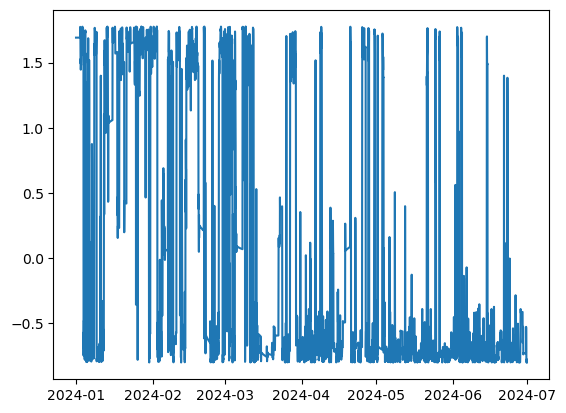

MWD_cos

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -7.4864
Results: {'pvalue': 4.625801574507973e-11, 'stationary': True, 'test_statistic': -7.486436989870942, 'used_lag': 30}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[61 65]
Seasonality identified for: 61
White Test for Heteroscedasticity: True with a p-value of 3.1129822653858454e-102


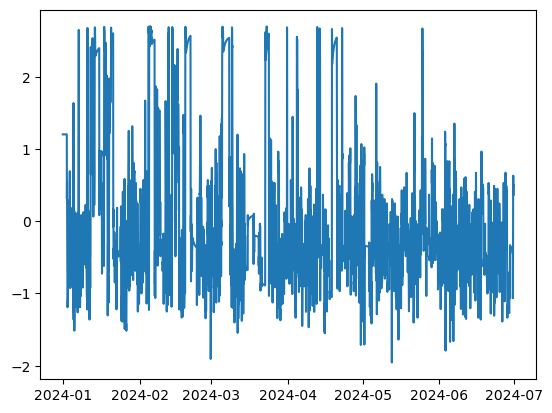

WSPD

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -8.7808
Results: {'pvalue': 2.379258885458067e-14, 'stationary': True, 'test_statistic': -8.78082983135054, 'used_lag': 22}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 49]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 0.0427042107145449


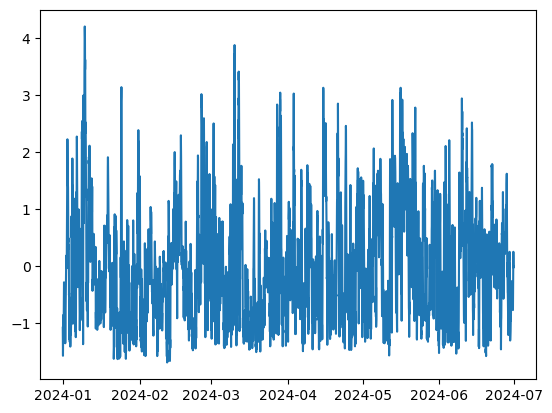

GST

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -8.6850
Results: {'pvalue': 4.1852943489723644e-14, 'stationary': True, 'test_statistic': -8.685049375466397, 'used_lag': 20}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[24 49]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 0.01811308177213882


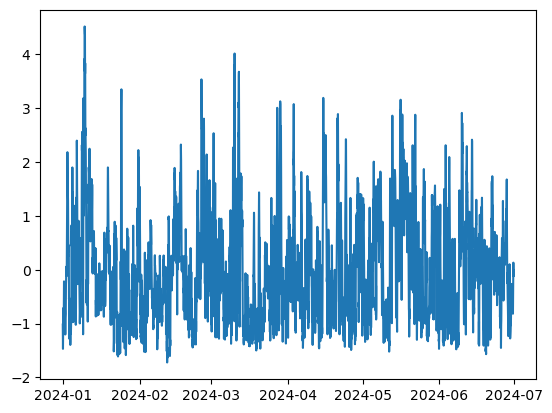

PRES

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -6.0004
Results: {'pvalue': 1.6624538569959565e-07, 'stationary': True, 'test_statistic': -6.000424363551698, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[]
The ACF has no local maximum for m < max_lag = 72. Try larger max_lag
Seasonality identified for: 0
White Test for Heteroscedasticity: True with a p-value of 1.0512800268557553e-72


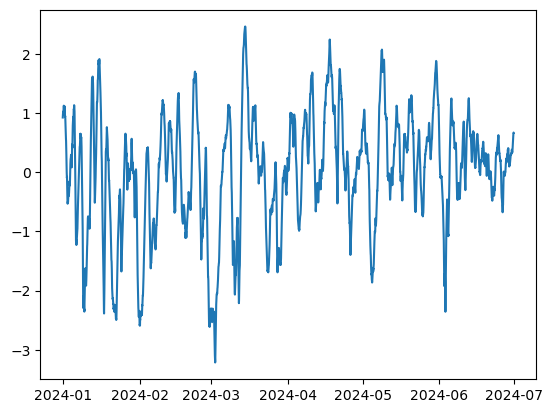

ATMP

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -3.2572
Results: {'pvalue': 0.016901183295541192, 'stationary': True, 'test_statistic': -3.2572453451583274, 'used_lag': 50}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[20 45 70]
Seasonality identified for: 20
White Test for Heteroscedasticity: True with a p-value of 8.192521422755905e-111


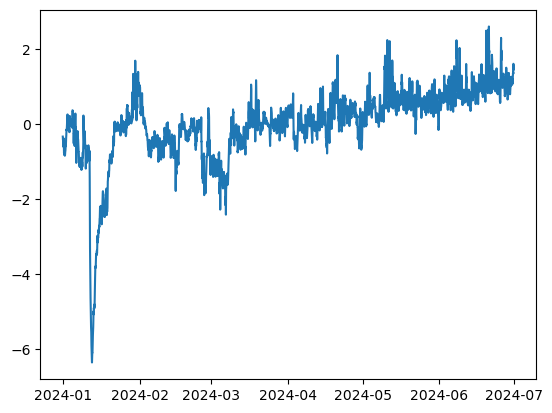

WTMP

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -0.4668
Results: {'pvalue': 0.898328116284242, 'stationary': False, 'test_statistic': -0.466831992807412, 'used_lag': 49}

Conclusion: The time series is Non-stationary at 5.0% significance level.
Null Hypothesis failed to reject
Mann-Kendalls: Trend: True | Direction: increasing 
[24 48]
Seasonality identified for: 24
White Test for Heteroscedasticity: True with a p-value of 1.2454157502138745e-133


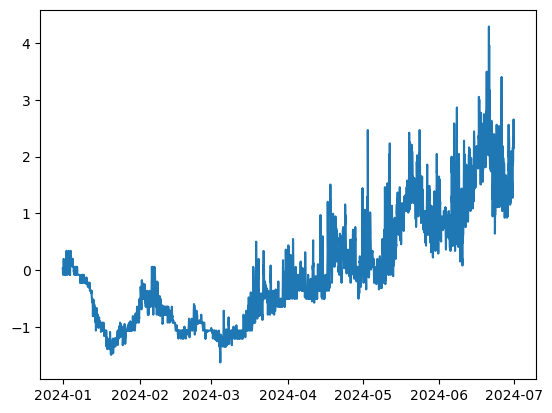

DEWP

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -3.7972
Results: {'pvalue': 0.002935844263446066, 'stationary': True, 'test_statistic': -3.7972240854222274, 'used_lag': 4}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: increasing 
[]
The ACF has no local maximum for m < max_lag = 72. Try larger max_lag
Seasonality identified for: 0
White Test for Heteroscedasticity: True with a p-value of 1.697891159639193e-145


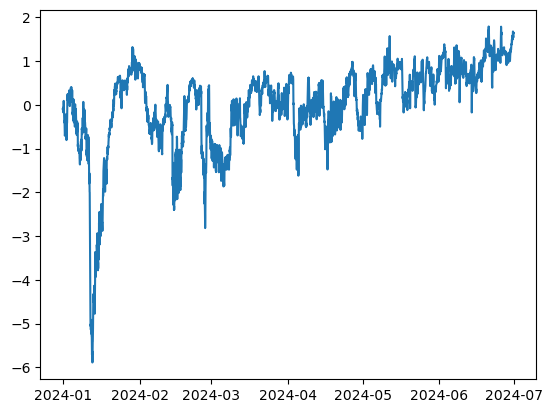

WDIR_sin

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -5.9532
Results: {'pvalue': 2.122729727004977e-07, 'stationary': True, 'test_statistic': -5.953233515367851, 'used_lag': 26}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[22 27 43 63 71]
Seasonality identified for: 22
White Test for Heteroscedasticity: True with a p-value of 9.815376155143097e-29


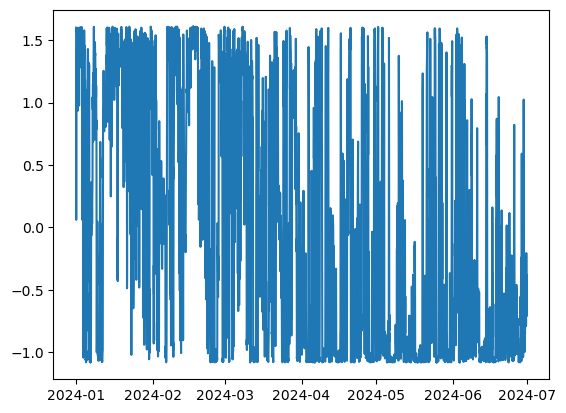

WDIR_cos

=== Augmented Dickey-Fuller Test Results ===
ADF Test Statistic: -8.9967
Results: {'pvalue': 6.6651043562119674e-15, 'stationary': True, 'test_statistic': -8.99669249342096, 'used_lag': 15}

Conclusion: The time series is Stationary at 5.0% significance level.
Null Hypothesis rejected
Mann-Kendalls: Trend: True | Direction: decreasing 
[17 38 45 49 51 55 65]
Seasonality identified for: 17
White Test for Heteroscedasticity: True with a p-value of 5.2898178308078336e-76


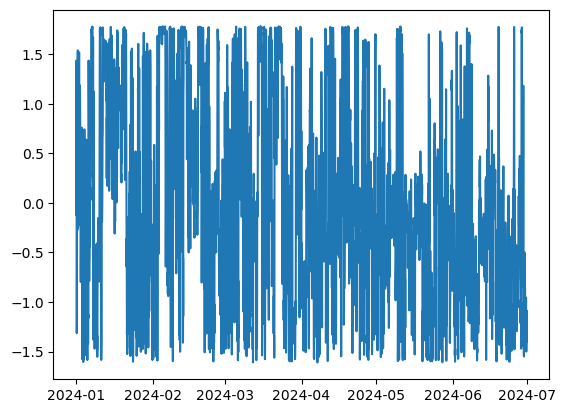

In [26]:
from statsmodels.tsa.stattools import adfuller
from sktime.param_est.stationarity import StationarityADF

exog_col = [col for col in processed_data_imputed.columns if col not in config.TARGETS]

for col in exog_col:
    print(col)
    series_col = processed_data_imputed[col]

    pipe = TransformerPipeline(
            steps = [
                ('scale', TabularToSeriesAdaptor(StandardScaler()))
            ]
        )

    col_transf = pipe.fit_transform(series_col)

    data_manager.test_stationarity(col_transf, plot = False)
    mann_kendall_res = data_manager.check_trend(col_transf, confidence=0.05)
    print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} ")

    seasonality_res = data_manager.check_seasonality(col_transf, max_lag=24*3, confidence=0.05)
    print(f"Seasonality identified for: {seasonality_res.seasonal_periods}")

    hetero_res = data_manager.check_heteroscedastisticity(col_transf, confidence=0.05)
    print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

    plt.plot(col_transf)
    plt.show()

